# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных
**Признаки:**
* **RowNumber** — индекс строки в данных
* **CustomerId** — уникальный идентификатор клиента
* **Surname** — фамилия
* **CreditScore** — кредитный рейтинг
* **Geography** — страна проживания
* **Gender** — пол
* **Age** — возраст
* **Tenure** — сколько лет человек является клиентом банка
* **Balance** — баланс на счёте
* **NumOfProducts** — количество продуктов банка, используемых клиентом
* **HasCrCard** — наличие кредитной карты
* **IsActiveMember** — активность клиента
* **EstimatedSalary** — предполагаемая зарплата

**Целевой признак**
* **Exited** — факт ухода клиента

# Цель

**Довести значением F1-меры модели минимум до 0.59**

## Подготовка данных

In [1]:
!pip install skimpy

In [2]:
!pip install phik

In [3]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from skimpy import clean_columns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/datasets/Churn.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
df.duplicated().sum()

0

В датасете в столбце Tenure(сколько лет человек является клиентом банка) есть пропуски, их можно заменить на 0, т.к. значит человек не является клиентом этого банка, а затем весь этот столбец привести в целочисленный тип. Также можно заметить, что в датасете есть столбцы, которые не понадобятся для анализа, поэтому их удалим. В целях работы с меньшем количеством данных.

In [8]:
extra_col = ['RowNumber', 'Surname', 'CustomerId', 'EstimatedSalary']
df = df.drop(extra_col, axis=1)

In [9]:
df['Tenure'] = df['Tenure'].fillna(0).astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     10000 non-null  int64  
 1   Geography       10000 non-null  object 
 2   Gender          10000 non-null  object 
 3   Age             10000 non-null  int64  
 4   Tenure          10000 non-null  int64  
 5   Balance         10000 non-null  float64
 6   NumOfProducts   10000 non-null  int64  
 7   HasCrCard       10000 non-null  int64  
 8   IsActiveMember  10000 non-null  int64  
 9   Exited          10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


Перевод названий столбцов в змеиный регистр

In [10]:
df = clean_columns(df)
df.head()

10 column names have been cleaned

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,exited
0,619,France,Female,42,2,0.00,1,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,0


Теперь датасет содержит 10000 строк и 9 столбцов, из которых 7 имеет целочисленный тип данных, в 2-ух столбцах данные представлены объектами, а последний представлен вещественным типом. В датасете нету пропусков и дубликатов. Также названия столбцов переведененны в нижний регистр.

## Исследование задачи

In [11]:
df.corr() # Считаю корреляцию Пирсона

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,exited
credit_score,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.027094
age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,0.285323
tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,-0.013319
balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.118533
num_of_products,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,-0.047820
has_cr_card,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.007138
is_active_member,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.156128
exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,1.000000


Видно, что все признаки не сильно коррелируются с целевым признаком.

Построим еще одну таблицу корреляции, только более сложную phik, в ней ищется не только линейная зависимость, но и не линейная, а метод Пирсона в пандасе исключительно ищет только линейную зависимость.

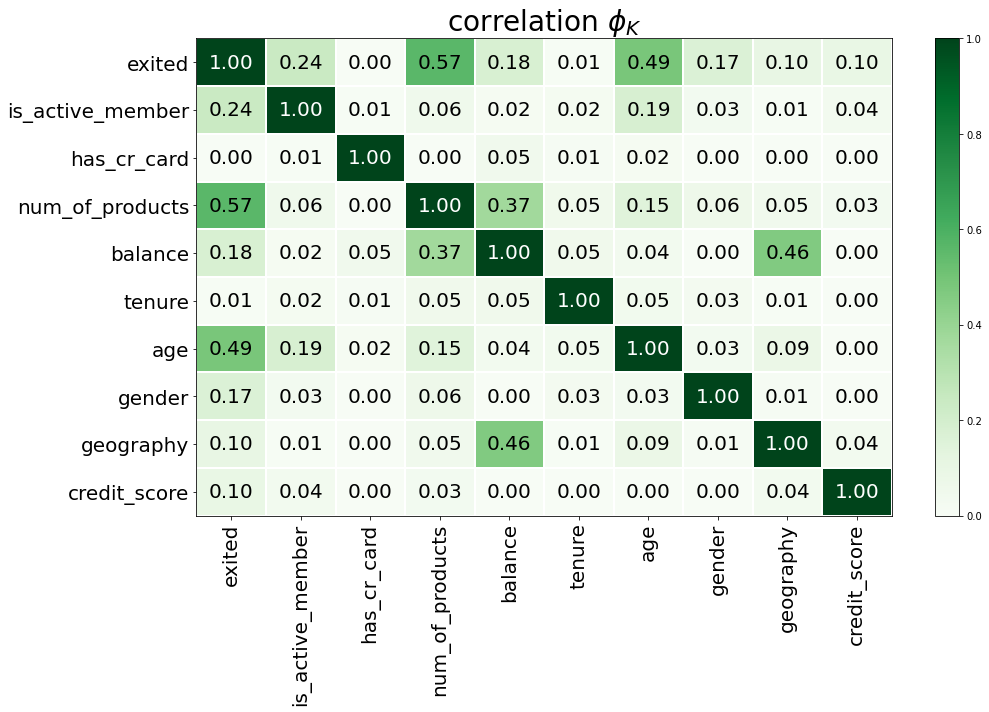

In [12]:
from phik.report import correlation_report, plot_correlation_matrix
interval_cols = df.select_dtypes('number').columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=2,
                        figsize=(15, 10))
plt.tight_layout()

Отобразим наиболее коррелирующие признаки для нашего целевого признака(exited)

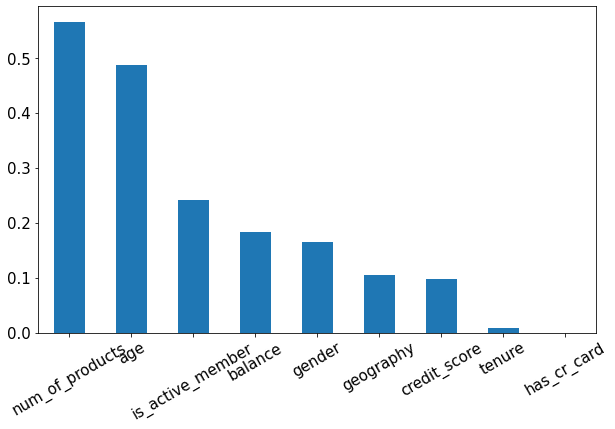

In [13]:
phik_overview['exited'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(10, 6), fontsize=15)
plt.xticks(rotation=30)
plt.show()

Самый сильно коррелирующий признак для exited это num_of_products(количество продуктов банка, используемых клиентом), потом идет age(возраст клиента), а у остальных не такая значимая корреляция.

Рассмотрим по отдельности некоторые признаки с целевым

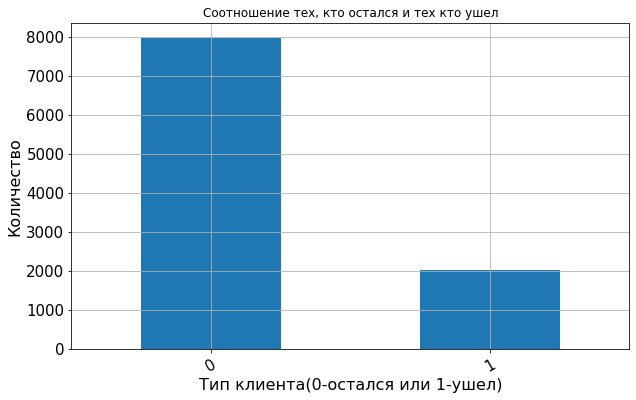

In [14]:
df['exited'].value_counts().plot(kind='bar', grid=True, figsize=(10, 6), fontsize=15)
plt.title('Соотношение тех, кто остался и тех кто ушел')
plt.ylabel('Количество', size=16)
plt.xlabel('Тип клиента(0-остался или 1-ушел)', size=16)
plt.xticks(rotation=30)
plt.show()

Можно заметить, что соотношение оттока и тех кто остался 1:4. ТОгда можно сделать вывод, что у нас присутствует сильный дисбаланс в данных, с чем мы будем позже работать.

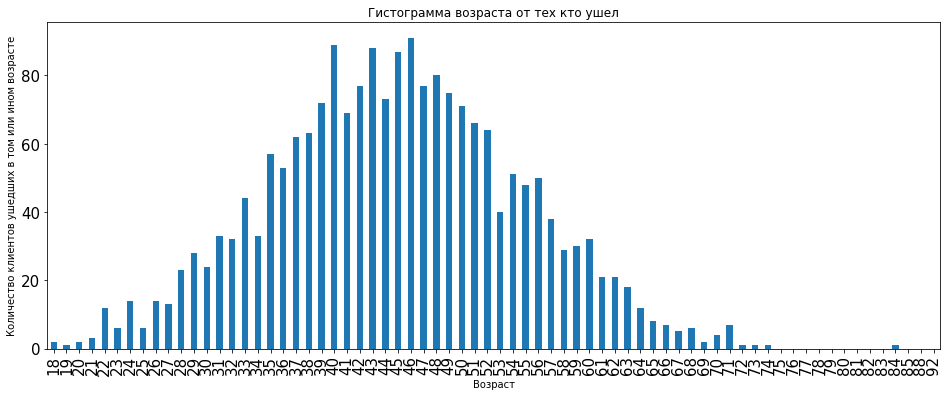

In [15]:
df.groupby('age')['exited'].sum().plot(kind='bar', figsize=(16, 6), fontsize=15)
plt.title('Гистограмма возраста от тех кто ушел')
plt.ylabel('Количество клиентов ушедших в том или ином возрасте')
plt.xlabel('Возраст')
plt.show()

По гистограмме можно заметить, что чаще всего клиенты уходят из банка в возрасте 40-50 лет.

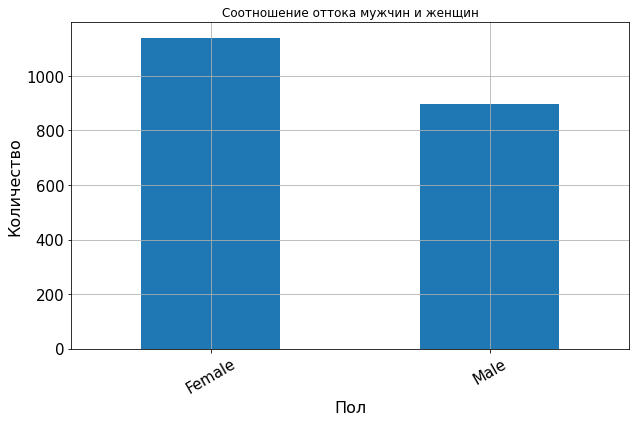

In [16]:
df.groupby('gender')['exited'].sum().plot(kind='bar', grid=True, figsize=(10, 6), fontsize=15)
plt.title('Соотношение оттока мужчин и женщин')
plt.ylabel('Количество', size=16)
plt.xlabel('Пол', size=16)
plt.xticks(rotation=30)
plt.show()

Можно заметить, что клиенты женского пола уходят больше чем клиенты мужского пола.

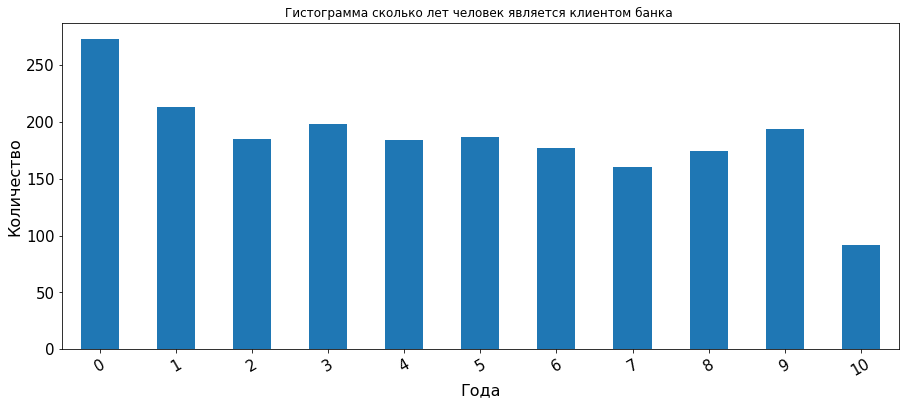

In [17]:
df.groupby('tenure')['exited'].sum().plot(figsize=(15,6), kind='bar', fontsize=15)
plt.title('Гистограмма сколько лет человек является клиентом банка ')
plt.ylabel('Количество', size=16)
plt.xlabel('Года', size=16)
plt.xticks(rotation=30)
plt.show()

На этой гистограмме слабо видно зависимость, поэтому точно сказать не могу кто чаще из клиентов уходит через какой-то срок.

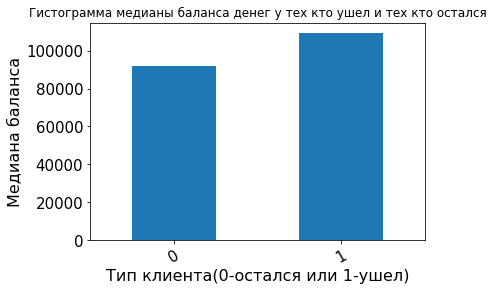

In [18]:
df.groupby('exited')['balance'].median().plot(kind='bar', fontsize=15)
plt.title('Гистограмма медианы баланса денег у тех кто ушел и тех кто остался')
plt.ylabel('Медиана баланса', size=16)
plt.xlabel('Тип клиента(0-остался или 1-ушел)', size=16)
plt.xticks(rotation=30)
plt.show()

На гистограмме видно, что медиана баланса денег немного больше у тех кто ушел.

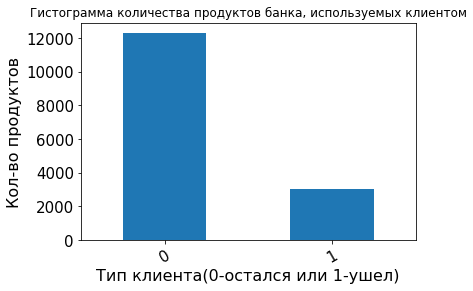

In [19]:
df.groupby('exited')['num_of_products'].sum().plot(kind='bar', fontsize=15)
plt.title('Гистограмма количества продуктов банка, используемых клиентом')
plt.ylabel('Кол-во продуктов', size=16)
plt.xlabel('Тип клиента(0-остался или 1-ушел)', size=16)
plt.xticks(rotation=30)
plt.show()

На гистограмме видно, что количество продуктов в банке у тех кто не ушли примерно в 4 раза больше, чем у тех кто ушли.

**One-Hot Encoding** 

Преобразовываем категориальные признаки в численные

Использовал функцию .get_dummies(drop_first=True), потому что к примеру у нас есть категориальный столбец geography после преобразования его, у нас добавятся 3 столбца, которые будут сильно связаны между собой, поэтому аргументом drop_first=True удалил первый столбец, чтобы не попасть в дамми-ловушку.

**Ordinal Encoding**

**Техника прямого кодирования OrdinalEncoding показала хуже результаты чем One-Hot Encoding(к примеру на модели дерева метрика F1 упала с 0,569 до 0,550; на логистической модели она упала с 0,293 до 0,238; а на модели случайного леса она увеличилась с 0,568 до 0,570, но это не сильно его изменила), поэтому я её закомментировал и использовал дальше One-Hot Encoding, т.к. он почти по всем моделям показал намного лучше результат**

**OneHotEncoder**, это тоже самое что и get_dummies, но он используется в промышленных маштабах, поэтому буду сразу делать им, так как нам сказали get_dummies не применяют в реальных проектах, его применяют только в маленьких проектах, чтобы быстро сделать и показать.

In [23]:
target = df['exited'] # Целевой признак
features = df.drop(['exited'], axis=1) # Признаки

In [24]:
# создаем объект OneHotEncoder, применив параметр drop = 'first'
# устраняем проблему dummy-ловушки
ohe = OneHotEncoder(sparse = False, drop='first')

In [25]:
# разделим features на два датасета, содержащие (1) числовые и
# (2) категориальные данные. Для кодировки предназначены только
# категориальные данные
features_numbers = features.drop(['geography', 'gender'], axis = 1)
print('Размер features_numbers:', features_numbers.shape)
features_category = features[['geography', 'gender']]
print('Размер features_category:', features_category.shape)

Размер features_numbers: (10000, 7)
Размер features_category: (10000, 2)


In [26]:
# создаем переменную features_ohe, в которую сохраняем
# обученную и трансформированную модель OneHotEncoder
features_ohe = ohe.fit_transform(features_category)
features_ohe

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [1., 0., 1.],
       [0., 0., 0.]])

In [27]:
# выведем список новых колонок, полученных после обучения и трансформации
# данных датасета features_category в модели OneHotEncoder
ohe.get_feature_names()

array(['x0_Germany', 'x0_Spain', 'x1_Male'], dtype=object)

In [28]:
# сохраним результаты кодирования в датафрейме features_ohe
features_ohe = pd.DataFrame(features_ohe, columns=ohe.get_feature_names())
features_ohe.head()

,x0_Germany,x0_Spain,x1_Male
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0


In [29]:
# объединим датасет с числовыми признаками features_numbers
# с датасетом features_ohe, содержащем закодированные данные категориальных признаков
features = features_numbers.merge(
    features_ohe,
    left_index = True,
    right_index = True
)
features

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,x0_Germany,x0_Spain,x1_Male
0,619,42,2,0.00,1,1,1,0.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,0.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,0.0,0.0,0.0
3,699,39,1,0.00,2,0,0,0.0,0.0,0.0
4,850,43,2,125510.82,1,1,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,0.0,0.0,1.0
9996,516,35,10,57369.61,1,1,1,0.0,0.0,1.0
9997,709,36,7,0.00,1,0,1,0.0,0.0,0.0
9998,772,42,3,75075.31,2,1,0,1.0,0.0,1.0


In [30]:
# приводим к стилю snake_case написание трех новых столбцов
features = clean_columns(features)
# выведем на экран размер обновленного датасета с признаками features
features.shape

3 column names have been cleaned

(10000, 10)

Подготовим данные для обучения модели

Отобразим наиболее коррелирующие признаки для нашего целевого признака(exited) методом **Mutual information** - статистическая функция двух случайных величин, описывающая количество информации, содержащееся в одной случайной величине относительно другой, это почти тоже самое что мы делали выше, только она ищет другим способом, поэтому они между собой немного различаются.

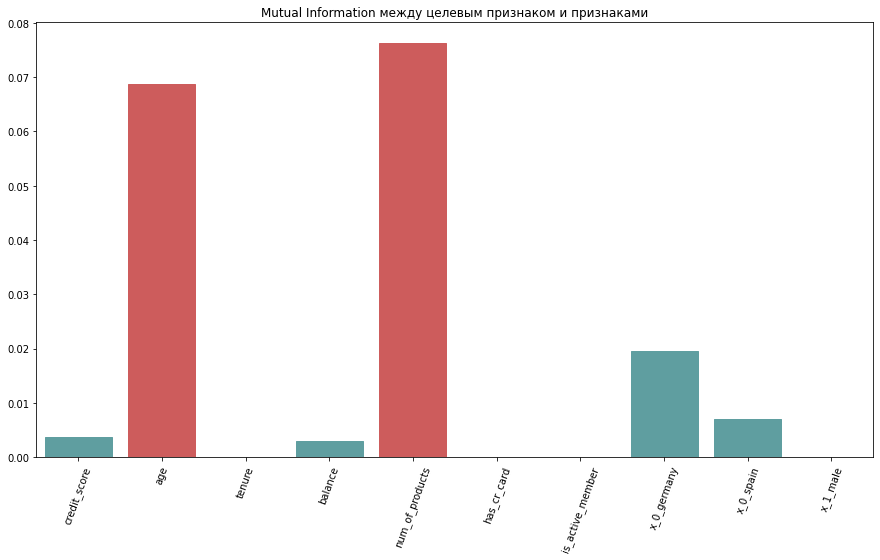

In [33]:
from sklearn.feature_selection import mutual_info_regression

# X = df.drop(['exited'], axis=1)# Признаки
# y = df['exited']# Целевой признак
# mi = mutual_info_regression(X, y, random_state=12345)
# sns.barplot(x=X.columns.tolist(), y=mi)

mi = mutual_info_regression(features, target, random_state = 1)
plt.figure(figsize = (15, 8))
ax = sns.barplot(x = features.columns.tolist(), y = mi)
plt.xticks(rotation = 70)
plt.title('Mutual Information между целевым признаком и признаками', \
          fontsize = 12)
for bar in ax.patches:
    if bar.get_height() > 0.04:
        bar.set_color('indianred')
    else:
        bar.set_color('cadetblue')
plt.show()

Разбиваем данные на четыре выборки

In [34]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, \
        test_size=0.25, random_state=12345)

Стандартизируем обучающую и валидационную выборки, т.к. есть в некоторых признаках большой разброс значений. 

In [35]:
#numeric = ['credit_score','age','tenure','balance','num_of_products','has_cr_card','is_active_member']
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

Рассмотрим ради интереса модель построенную по двум самым влиямым признакам

**Построим модели без учета баланса классов**

**Модель Дерево решения**

In [37]:
best_model_tree = None
best_depth = 0
best_f1_tree = 0
for depth in range(1, 11, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions = model_tree.predict(features_valid) # получил предсказания модели
    f1_tree = f1_score(target_valid, predictions) #получил среднее гармоничное полноты и точности
    if f1_tree > best_f1_tree:
        best_f1_tree = f1_tree
        best_model_tree = model_tree
        best_depth = depth
print('max_depth:', best_depth, 'F1:', best_f1_tree, sep='\n')

max_depth:
5
F1:
0.5691609977324262


**Вывод:** лучшее значение дерева max_depth = 5, при котором F1 = 0,569

**Модель Случайный лес**

In [38]:
%%time
best_model = None
best_est = 0
best_depth = 0
best_f1_forest = 0
best_sample_leaf = 0
for est in tqdm(range(10, 51, 10)):
    for depth in range (1, 11):
        for sample in range(1, 11):
            model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, min_samples_leaf=sample) # инициализировал модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
            model_forest.fit(features_train, target_train) # обучил модель на тренировочной выборке
            predictions_forest = model_forest.predict(features_valid) # получил предсказания модели
            f1_forest = f1_score(target_valid, predictions_forest) #получил среднее гармоничное полноты и точности
            if f1_forest > best_f1_forest:
                best_f1_forest = f1_forest
                best_model = model_forest
                best_est = est
                best_depth = depth
                best_sample_leaf = sample
print(f'Качество классификации(F1) модели: {best_f1_forest} при глубине дерева {depth}, количестве деревьев {est} и объектов в листьях дерева {best_sample_leaf}')

100%|██████████| 5/5 [00:56<00:00, 11.39s/it]

Качество классификации(F1) модели: 0.5686274509803921 при глубине дерева 10, количестве деревьев 50 и объектов в листьях дерева 1
CPU times: user 56.6 s, sys: 290 ms, total: 56.9 s
Wall time: 56.9 s


**Вывод:** лучшии значения случайного леса max_depth = 10, n_estimators=50, min_samples_leaf=1 - при которых F1 = 0,568

**Модель Логистической регрессии**

In [40]:
model_logic = LogisticRegression(random_state=12345, solver='lbfgs')
model_logic.fit(features_train, target_train)

predictions_logic = model_logic.predict(features_valid)

f1_logic = f1_score(target_valid, predictions_logic) #получил среднее гармоничное полноты и точности
print(f'F1 логистической модели: {f1_logic}')

F1 логистической модели: 0.2937062937062937


**Вывод:** F1 логистической модели = 0,293

**Общий вывод:**

Рассматривая данные с дисбалансом, но с переведенными категориальными и стандартизированными данными, можно сделать вывод по трем моделям, что саммая лучшая модель оказалась Дерево решения(при лучшем значении max_depth = 5, мы имеем F1 меру = 0,569 на валидационной(тестовой) выборке). Модель Случайного леса показала совсем немного хуже ее F1 мера равна = 0,568. А модель Логистической регрессии показала самый худший результат ее F1 мера = 0,293.

## Борьба с дисбалансом

In [41]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

**SMOTE**

Original dataset: [(0, 5998), (1, 1502)]
Sampled dataset: [(0, 5998), (1, 5998)]


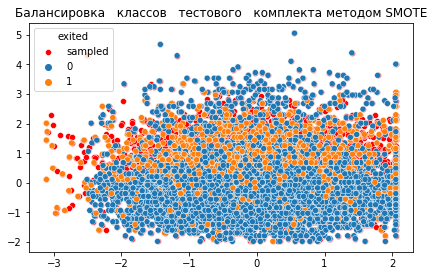

In [42]:
# устраняем дисбаланс классов в обучающем комплекте
# методом SMOTE
features_smote, target_smote = SMOTE().fit_resample(features_train, target_train)
print("Original dataset:", sorted(Counter(target_train).items()))
print("Sampled dataset:", sorted(Counter(target_smote).items()))
# визуализируем результаты устранения дисбаланса классов
sns.scatterplot(
    x=features_smote[:,0], 
    y=features_smote[:,1], 
    color='r', 
    label='sampled')
sns.scatterplot(
    x=features_train[:,0], 
    y=features_train[:,1], 
    hue=target_train)
sns.set(rc={'figure.figsize':(8,6)})
plt.title('Балансировка   классов   тестового   комплекта методом SMOTE', fontsize=12)
plt.tight_layout()
plt.show()

**Модель Случайного леса с балансировкой классов методом SMOTE**

In [43]:
%%time

model_forest_sm = RandomForestClassifier(random_state=12345)

forest_params_sm = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_sm = GridSearchCV(model_forest_sm, forest_params_sm, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_forest_sm.fit(features_smote, target_smote)
best_model_forest_sm = grid_model_forest_sm.best_estimator_
print(best_model_forest_sm)
print(grid_model_forest_sm.best_params_)

predicted_forest_sm = best_model_forest_sm.predict(features_smote)
f1_score_forest_sm = f1_score(target_smote, predicted_forest_sm)
print('f1_score на выборке features_smote =', round(f1_score_forest_sm, 4))

probabilities_forest_sm = (best_model_forest_sm.predict_proba(features_smote))[:, 1]
roc_auc_forest_sm = roc_auc_score(target_smote, probabilities_forest_sm)
print('roc-auc на выборке features_smote =', round(roc_auc_forest_sm, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       random_state=12345)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
f1_score на выборке features_smote = 0.8875
roc-auc на выборке features_smote = 0.9579
CPU times: user 2min 19s, sys: 648 ms, total: 2min 20s
Wall time: 2min 20s


**Модель Дерева решения с балансировкой классов методом SMOTE**

In [2]:
%%time

model_tree_sm = DecisionTreeClassifier(random_state=12345)

tree_params_sm = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }


grid_model_tree_sm = GridSearchCV(model_tree_sm, tree_params_sm, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_tree_sm.fit(features_smote, target_smote)
best_model_tree_sm = grid_model_tree_sm.best_estimator_
print(best_model_tree_sm)
print(grid_model_tree_sm.best_params_)

predicted_tree_sm = best_model_tree_sm.predict(features_smote)
f1_score_tree_sm = f1_score(target_smote, predicted_tree_sm)
print('f1_score на выборке features_smote =', round(f1_score_tree_sm, 4))

probabilities_tree_sm = (best_model_tree_sm.predict_proba(features_smote))[:, 1]
roc_auc_tree_sm = roc_auc_score(target_smote, probabilities_tree_sm)
print('roc-auc на выборке features_smote =', round(roc_auc_tree_sm, 4))

**Модель Логистической регрессии с балансировкой классов методом SMOTE**

In [45]:
%%time

model_logic_sm = LogisticRegression(random_state=12345)

logic_params_sm = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(100, 5001, 100)
    }

grid_model_logic_sm = GridSearchCV(model_logic_sm, logic_params_sm, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_logic_sm.fit(features_smote, target_smote)
best_model_logic_sm = grid_model_logic_sm.best_estimator_
print(best_model_logic_sm)
print(grid_model_logic_sm.best_params_)

predicted_logic_sm = best_model_logic_sm.predict(features_smote)
f1_score_logic_sm = f1_score(target_smote, predicted_logic_sm)
print('f1_score на выборке features_smote =', round(f1_score_logic_sm, 4))

probabilities_logic_sm = (best_model_logic_sm.predict_proba(features_smote))[:, 1]
roc_auc_logic_sm = roc_auc_score(target_smote, probabilities_logic_sm)
print('roc-auc на выборке features_smote =', round(roc_auc_logic_sm, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
LogisticRegression(random_state=12345, solver='newton-cg')
{'max_iter': 100, 'solver': 'newton-cg'}
f1_score на выборке features_smote = 0.7094
roc-auc на выборке features_smote = 0.7794
CPU times: user 52.9 s, sys: 1min 53s, total: 2min 46s
Wall time: 2min 46s


**Лучшие метрики после балансировки методом SMOTE показала модель Случайного леса**

**ADASYN**

Original dataset: [(0, 5998), (1, 1502)]
Sampled dataset: [(0, 5998), (1, 5785)]


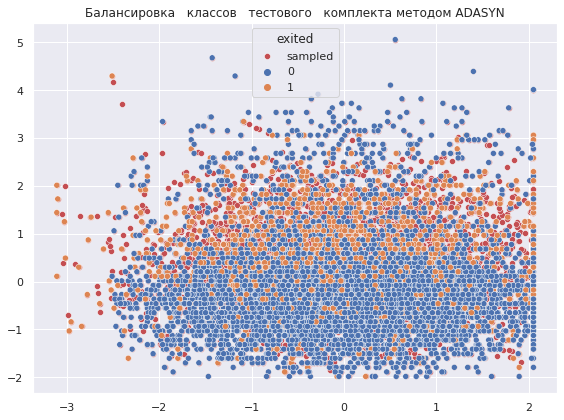

In [46]:
# устраняем дисбаланс классов в обучающем комплекте
# методом ADASYN
features_adasyn, target_adasyn = ADASYN().fit_resample(features_train, target_train)
print("Original dataset:", sorted(Counter(target_train).items()))
print("Sampled dataset:", sorted(Counter(target_adasyn).items()))
# визуализируем результаты устранения дисбаланса классов
sns.scatterplot(
    x=features_adasyn[:,0], 
    y=features_adasyn[:,1], 
    color='r', 
    label='sampled')
sns.scatterplot(
    x=features_train[:,0], 
    y=features_train[:,1], 
    hue=target_train)
sns.set(rc={'figure.figsize':(10,8)})
plt.title('Балансировка   классов   тестового   комплекта методом ADASYN', fontsize=12)
plt.tight_layout()
plt.show()

**Модель Случайного леса с балансировкой классов методом ADASYN**

In [47]:
%%time

model_forest_ad = RandomForestClassifier(random_state=12345)

forest_params_ad = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_ad = GridSearchCV(model_forest_ad, forest_params_ad, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_forest_ad.fit(features_adasyn, target_adasyn)
best_model_forest_ad = grid_model_forest_ad.best_estimator_
print(best_model_forest_ad)
print(grid_model_forest_ad.best_params_)

predicted_forest_ad = best_model_forest_ad.predict(features_adasyn)
f1_score_forest_ad = f1_score(target_adasyn, predicted_forest_ad)
print('f1_score на выборке features_adasyn =', round(f1_score_forest_ad, 4))

probabilities_forest_ad = (best_model_forest_ad.predict_proba(features_adasyn))[:, 1]
roc_auc_forest_ad = roc_auc_score(target_adasyn, probabilities_forest_ad)
print('roc-auc на выборке features_adasyn =', round(roc_auc_forest_ad, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=30,
                       random_state=12345)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 30}
f1_score на выборке features_adasyn = 0.8763
roc-auc на выборке features_adasyn = 0.9505
CPU times: user 2min 13s, sys: 406 ms, total: 2min 13s
Wall time: 2min 14s


**Модель Дерева решения с балансировкой классов методом ADASYN**

In [48]:
%%time

model_tree_ad = DecisionTreeClassifier(random_state=12345)

tree_params_ad = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }


grid_model_tree_ad = GridSearchCV(model_tree_ad, tree_params_ad, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_tree_ad.fit(features_adasyn, target_adasyn)
best_model_tree_ad = grid_model_tree_ad.best_estimator_
print(best_model_tree_ad)
print(grid_model_tree_ad.best_params_)

predicted_tree_ad = best_model_tree_ad.predict(features_adasyn)
f1_score_tree_ad = f1_score(target_adasyn, predicted_tree_ad)
print('f1_score на выборке features_adasyn =', round(f1_score_tree_ad, 4))

probabilities_tree_ad = (best_model_tree_ad.predict_proba(features_adasyn))[:, 1]
roc_auc_tree_ad = roc_auc_score(target_adasyn, probabilities_tree_ad)
print('roc-auc на выборке features_adasyn =', round(roc_auc_tree_ad, 4))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=12345)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}
f1_score на выборке features_adasyn = 0.8411
roc-auc на выборке features_adasyn = 0.9332
CPU times: user 3.41 s, sys: 0 ns, total: 3.41 s
Wall time: 3.42 s


**Модель Логистической регрессии с балансировкой классов методом ADASYN**

In [49]:
%%time

model_logic_ad = LogisticRegression(random_state=12345)

logic_params_ad = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(100, 5001, 100)
    }

grid_model_logic_ad = GridSearchCV(model_logic_ad, logic_params_ad, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_logic_ad.fit(features_adasyn, target_adasyn)
best_model_logic_ad = grid_model_logic_ad.best_estimator_
print(best_model_logic_ad)
print(grid_model_logic_ad.best_params_)

predicted_logic_ad = best_model_logic_ad.predict(features_adasyn)
f1_score_logic_ad = f1_score(target_adasyn, predicted_logic_ad)
print('f1_score на выборке features_adasyn =', round(f1_score_logic_ad, 4))

probabilities_logic_ad = (best_model_logic_ad.predict_proba(features_adasyn))[:, 1]
roc_auc_logic_ad = roc_auc_score(target_adasyn, probabilities_logic_ad)
print('roc-auc на выборке features_adasyn =', round(roc_auc_logic_ad, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
LogisticRegression(random_state=12345, solver='newton-cg')
{'max_iter': 100, 'solver': 'newton-cg'}
f1_score на выборке features_adasyn = 0.6621
roc-auc на выборке features_adasyn = 0.7372
CPU times: user 1min 8s, sys: 2min 46s, total: 3min 55s
Wall time: 3min 55s


**Лучшие метрики после балансировки методом ADASYN показала модель Случайного леса**

**RandomUnderSampler**

Original dataset: [(0, 5998), (1, 1502)]
Sampled dataset: [(0, 1502), (1, 1502)]


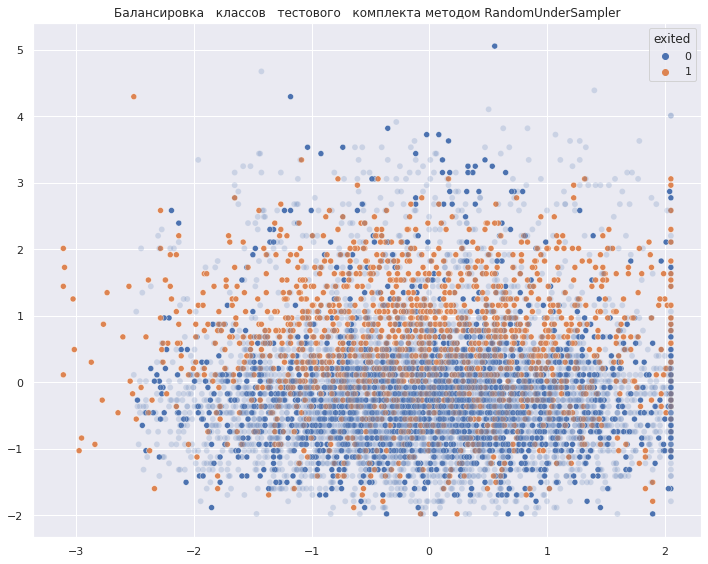

In [50]:
# устраняем дисбаланс классов в обучающем комплекте
# методом RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
features_ros, target_ros = ros.fit_resample(features_train, target_train)
print("Original dataset:", sorted(Counter(target_train).items()))
print("Sampled dataset:", sorted(Counter(target_ros).items()))
# визуализируем результаты устранения дисбаланса классов
sns.scatterplot(
    x=features_ros[:,0], 
    y=features_ros[:,1],
    hue=target_ros,
    legend=None)
sns.scatterplot(
    x=features_train[:,0], 
    y=features_train[:,1], 
    hue=target_train,
    alpha=0.2)
sns.set(rc={'figure.figsize':(10,8)})
plt.title('Балансировка   классов   тестового   комплекта методом RandomUnderSampler', fontsize=12)
plt.tight_layout()
plt.show()

**Модель Случайного леса с балансировкой классов методом RandomUnderSampler**

In [51]:
%%time

model_forest_ros = RandomForestClassifier(random_state=12345)

forest_params_ros = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_ros = GridSearchCV(model_forest_ros, forest_params_ros, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_forest_ros.fit(features_ros, target_ros)
best_model_forest_ros = grid_model_forest_ros.best_estimator_
print(best_model_forest_ros)
print(grid_model_forest_ros.best_params_)

predicted_forest_ros = best_model_forest_ros.predict(features_ros)
f1_score_forest_ros = f1_score(target_ros, predicted_forest_ros)
print('f1_score на выборке features_ros =', round(f1_score_forest_ros, 4))

probabilities_forest_ros = (best_model_forest_ros.predict_proba(features_ros))[:, 1]
roc_auc_forest_ros = roc_auc_score(target_ros, probabilities_forest_ros)
print('roc-auc на выборке features_ros =', round(roc_auc_forest_ros, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       n_estimators=40, random_state=12345)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 40}
f1_score на выборке features_ros = 0.854
roc-auc на выборке features_ros = 0.9418
CPU times: user 52.6 s, sys: 454 ms, total: 53 s
Wall time: 53.1 s


**Модель Дерева решения с балансировкой классов методом RandomUnderSampler**

In [52]:
%%time

model_tree_ros = DecisionTreeClassifier(random_state=12345)

tree_params_ros = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }


grid_model_tree_ros = GridSearchCV(model_tree_ros, tree_params_ros, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_tree_ros.fit(features_ros, target_ros)
best_model_tree_ros = grid_model_tree_ros.best_estimator_
print(best_model_tree_ros)
print(grid_model_tree_ros.best_params_)

predicted_tree_ros = best_model_tree_ros.predict(features_ros)
f1_score_tree_ros = f1_score(target_ros, predicted_tree_ros)
print('f1_score на выборке features_ros =', round(f1_score_tree_ros, 4))

probabilities_tree_ros = (best_model_tree_ros.predict_proba(features_ros))[:, 1]
roc_auc_tree_ros = roc_auc_score(target_ros, probabilities_tree_ros)
print('roc-auc на выборке features_ros =', round(roc_auc_tree_ros, 4))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       random_state=12345)
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3}
f1_score на выборке features_ros = 0.7971
roc-auc на выборке features_ros = 0.885
CPU times: user 948 ms, sys: 6.43 ms, total: 954 ms
Wall time: 961 ms


**Модель Логистической регрессии с балансировкой классов методом RandomUnderSampler**

In [53]:
%%time

model_logic_ros = LogisticRegression(random_state=12345)

logic_params_ros = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(100, 5001, 100)
    }

grid_model_logic_ros = GridSearchCV(model_logic_ros, logic_params_ros, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_logic_ros.fit(features_ros, target_ros)
best_model_logic_ros = grid_model_logic_ros.best_estimator_
print(best_model_logic_ros)
print(grid_model_logic_ros.best_params_)

predicted_logic_ros = best_model_logic_ros.predict(features_ros)
f1_score_logic_ros = f1_score(target_ros, predicted_logic_ros)
print('f1_score на выборке features_ros =', round(f1_score_logic_ros, 4))

probabilities_logic_ros = (best_model_logic_ros.predict_proba(features_ros))[:, 1]
roc_auc_logic_ros = roc_auc_score(target_ros, probabilities_logic_ros)
print('roc-auc на выборке features_ros =', round(roc_auc_logic_ros, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
LogisticRegression(random_state=12345, solver='newton-cg')
{'max_iter': 100, 'solver': 'newton-cg'}
f1_score на выборке features_ros = 0.7066
roc-auc на выборке features_ros = 0.7761
CPU times: user 49.5 s, sys: 2min 12s, total: 3min 2s
Wall time: 3min 2s


**Лучшие метрики после балансировки методом RandomUnderSampler показала модель Случайного леса**

**SMOTETomek**

Original dataset: [(0, 5998), (1, 1502)]
Sampled dataset: [(0, 5830), (1, 5830)]


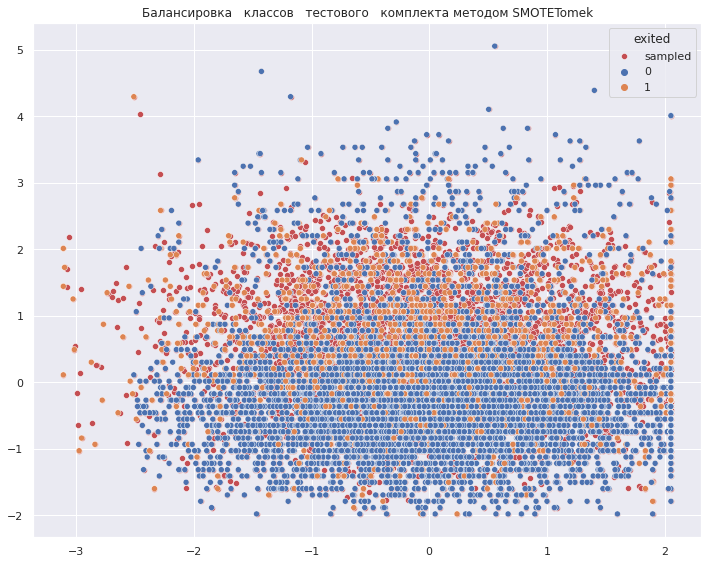

In [54]:
# устраняем дисбаланс классов в обучающем комплекте
# методом SMOTETomek
smote_tomek = SMOTETomek(random_state=12345)
features_smote_tomek, target_smote_tomek = smote_tomek.fit_resample(features_train, target_train)
print("Original dataset:", sorted(Counter(target_train).items()))
print("Sampled dataset:", sorted(Counter(target_smote_tomek).items()))
# визуализируем результаты устранения дисбаланса классов
sns.scatterplot(
    x=features_smote_tomek[:,0], 
    y=features_smote_tomek[:,1], 
    color='r', 
    label='sampled')
sns.scatterplot(
    x=features_train[:,0], 
    y=features_train[:,1], 
    hue=target_train)
sns.set(rc={'figure.figsize':(10,8)})
plt.title('Балансировка   классов   тестового   комплекта методом SMOTETomek', fontsize=12)
plt.tight_layout()
plt.show()

**Модель Случайного леса с балансировкой классов методом SMOTETomek**

In [55]:
%%time

model_forest_st = RandomForestClassifier(random_state=12345)

forest_params_st = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_st = GridSearchCV(model_forest_st, forest_params_st, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_forest_st.fit(features_smote_tomek, target_smote_tomek)
best_model_forest_st = grid_model_forest_st.best_estimator_
print(best_model_forest_st)
print(grid_model_forest_st.best_params_)

predicted_forest_st = best_model_forest_st.predict(features_smote_tomek)
f1_score_forest_st = f1_score(target_smote_tomek, predicted_forest_st)
print('f1_score на выборке features_smote_tomek =', round(f1_score_forest_st, 4))

probabilities_forest_st = (best_model_forest_st.predict_proba(features_smote_tomek))[:, 1]
roc_auc_forest_st = roc_auc_score(target_smote_tomek, probabilities_forest_st)
print('roc-auc на выборке features_smote_tomek =', round(roc_auc_forest_st, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       random_state=12345)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
f1_score на выборке features_smote_tomek = 0.8908
roc-auc на выборке features_smote_tomek = 0.9622
CPU times: user 2min 21s, sys: 685 ms, total: 2min 22s
Wall time: 2min 22s


**Модель Дерева решения с балансировкой классов методом SMOTETomek**

In [56]:
%%time

model_tree_st = DecisionTreeClassifier(random_state=12345)

tree_params_st = {
    'criterion': ['entropy'],
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }


grid_model_tree_st = GridSearchCV(model_tree_st, tree_params_st, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_tree_st.fit(features_smote_tomek, target_smote_tomek)
best_model_tree_st = grid_model_tree_st.best_estimator_
print(best_model_tree_st)
print(grid_model_tree_st.best_params_)

predicted_tree_st = best_model_tree_st.predict(features_smote_tomek)
f1_score_tree_st = f1_score(target_smote_tomek, predicted_tree_st)
print('f1_score на выборке features_smote_tomek =', round(f1_score_tree_st, 4))

probabilities_tree_st = (best_model_tree_st.predict_proba(features_smote_tomek))[:, 1]
roc_auc_tree_st = roc_auc_score(target_smote_tomek, probabilities_tree_st)
print('roc-auc на выборке features_smote_tomek =', round(roc_auc_tree_st, 4))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=12345)
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}
f1_score на выборке features_smote_tomek = 0.8478
roc-auc на выборке features_smote_tomek = 0.9346
CPU times: user 3.68 s, sys: 10.9 ms, total: 3.69 s
Wall time: 3.7 s


**Модель Логистической регрессии с балансировкой классов методом SMOTETomek**

In [57]:
%%time

model_logic_st = LogisticRegression(random_state=12345)

logic_params_st = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': range(100, 5001, 100)
    }

grid_model_logic_st = GridSearchCV(model_logic_st, logic_params_st, cv=5, scoring = 'f1', refit=True, verbose=1)

grid_model_logic_st.fit(features_smote_tomek, target_smote_tomek)
best_model_logic_st = grid_model_logic_st.best_estimator_
print(best_model_logic_st)
print(grid_model_logic_st.best_params_)

predicted_logic_st = best_model_logic_st.predict(features_smote_tomek)
f1_score_logic_st = f1_score(target_smote_tomek, predicted_logic_st)
print('f1_score на выборке features_smote_tomek =', round(f1_score_logic_st, 4))

probabilities_logic_st = (best_model_logic_st.predict_proba(features_smote_tomek))[:, 1]
roc_auc_logic_st = roc_auc_score(target_smote_tomek, probabilities_logic_st)
print('roc-auc на выборке features_smote_tomek =', round(roc_auc_logic_st, 4))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
LogisticRegression(random_state=12345, solver='liblinear')
{'max_iter': 100, 'solver': 'liblinear'}
f1_score на выборке features_smote_tomek = 0.71
roc-auc на выборке features_smote_tomek = 0.7858
CPU times: user 1min 11s, sys: 2min 50s, total: 4min 1s
Wall time: 4min 2s


**Лучшие метрики после балансировки методом SMOTETomek показала модель Случайного леса**

### Общий вывод: 

**Лучшие метрики по всем 4 методам балансировки данных показала модель Случайного леса**

**Метод показавший наивысшие метрики на обучающей выборке это SMOTETomek, поэтому тестирование модели на тестовой(валидационной) выборке буду делать по лучшим моделям полученными при балансировке данных методом SMOTETomek.**

## Тестирование модели

**Результаты метрик F1 и AUC-ROC моделей Случайного леса на тестовой выборке**

Рассмотрим какая из моделей Случайного леса покажет наилучшие метрики:

после балансировки данных методом SMOTE

In [58]:
best_predicted_forest_sm = best_model_forest_sm.predict(features_valid)
best_f1_score_forest_sm = f1_score(target_valid, best_predicted_forest_sm)
print('f1_score на выборке features_valid =', round(best_f1_score_forest_sm, 4))

best_probabilities_forest_sm = (best_model_forest_sm.predict_proba(features_valid))[:, 1]
best_roc_auc_forest_sm = roc_auc_score(target_valid, best_probabilities_forest_sm)
fpr_sm, tpr_sm, thresholds = roc_curve(target_valid, best_probabilities_forest_sm)
print('auc_roc на выборке features_valid =', round(best_roc_auc_forest_sm, 4))

f1_score на выборке features_valid = 0.6216
auc_roc на выборке features_valid = 0.8611


после балансировки данных методом ADASYN

In [59]:
best_predicted_forest_ad = best_model_forest_ad.predict(features_valid)
best_f1_score_forest_ad = f1_score(target_valid, best_predicted_forest_ad)
print('f1_score на выборке features_valid =', round(best_f1_score_forest_ad, 4))

best_probabilities_forest_ad = (best_model_forest_ad.predict_proba(features_valid))[:, 1]
best_roc_auc_forest_ad = roc_auc_score(target_valid, best_probabilities_forest_ad)
fpr_ad, tpr_ad, thresholds = roc_curve(target_valid, best_probabilities_forest_ad)
print('auc_roc на выборке features_valid =', round(best_roc_auc_forest_ad, 4))

f1_score на выборке features_valid = 0.6212
auc_roc на выборке features_valid = 0.8559


после балансировки данных методом RandomUnderSampler

In [60]:
best_predicted_forest_ros = best_model_forest_ros.predict(features_valid)
best_f1_score_forest_ros = f1_score(target_valid, best_predicted_forest_ros)
print('f1_score на выборке features_valid =', round(best_f1_score_forest_ros, 4))

best_probabilities_forest_ros = (best_model_forest_ros.predict_proba(features_valid))[:, 1]
best_roc_auc_forest_ros = roc_auc_score(target_valid, best_probabilities_forest_ros)
fpr_roc, tpr_roc, thresholds = roc_curve(target_valid, best_probabilities_forest_ros)
print('auc_roc на выборке features_valid =', round(best_roc_auc_forest_ros, 4))

f1_score на выборке features_valid = 0.6244
auc_roc на выборке features_valid = 0.8616


после балансировки данных методом SMOTETomek

In [61]:
best_predicted_forest_st = best_model_forest_st.predict(features_valid)
best_f1_score_forest_st = f1_score(target_valid, best_predicted_forest_st)
print('f1_score на выборке features_valid =', round(best_f1_score_forest_st, 4))

best_probabilities_forest_st = (best_model_forest_st.predict_proba(features_valid))[:, 1]
best_roc_auc_forest_st = roc_auc_score(target_valid, best_probabilities_forest_st)
fpr_st, tpr_st, thresholds = roc_curve(target_valid, best_probabilities_forest_st)
print('auc_roc на выборке features_valid =', round(best_roc_auc_forest_st, 4))

f1_score на выборке features_valid = 0.6409
auc_roc на выборке features_valid = 0.8637


**Лучшие результаты показала модель Случайного леса при балансировки данных методом SMOTETomek на тестовой выборке:**
* F1 = 0.6409
* AUC-ROC = 0.8637

**Построим ROC-кривую для 4 модлей Случайного леса обработанных разными способами**

<Figure size 720x576 with 0 Axes>

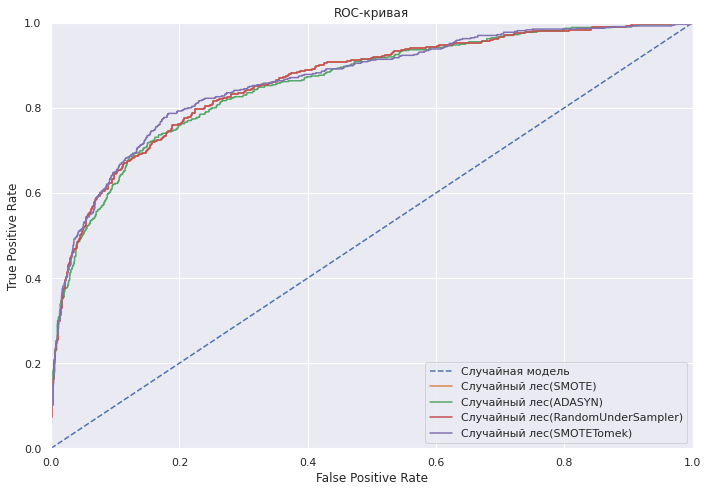

In [62]:
plt.figure()
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_sm, tpr_sm)
plt.plot(fpr_ad, tpr_ad)
plt.plot(fpr_sm, tpr_sm)
plt.plot(fpr_st, tpr_st)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес(SMOTE)','Случайный лес(ADASYN)',
            'Случайный лес(RandomUnderSampler)', 'Случайный лес(SMOTETomek)')) 
plt.tight_layout()
plt.show()

Результаты этих моделей приближенны к друг другу, поэтому они почти совпадают.

**Потроим ROC-кривую для Дерева решения, Случайного леса и Логистической регрессии сбалансированных методом SMOTETomek**

In [63]:
best_predicted_tree_st = best_model_tree_st.predict(features_valid)
best_f1_score_tree_st = f1_score(target_valid, best_predicted_tree_st)
print('f1_score на выборке features_valid =', round(best_f1_score_tree_st, 4))

best_probabilities_tree_st = (best_model_tree_st.predict_proba(features_valid))[:, 1]
best_roc_auc_tree_st = roc_auc_score(target_valid, best_probabilities_tree_st)
fpr_tree_st, tpr_tree_st, thresholds = roc_curve(target_valid, best_probabilities_tree_st)
print('auc_roc на выборке features_valid =', round(best_roc_auc_tree_st, 4))

f1_score на выборке features_valid = 0.6005
auc_roc на выборке features_valid = 0.8286


In [64]:
best_predicted_logic_st = best_model_logic_st.predict(features_valid)
best_f1_score_logic_st = f1_score(target_valid, best_predicted_logic_st)
print('f1_score на выборке features_valid =', round(best_f1_score_logic_st, 4))

best_probabilities_logic_st = (best_model_logic_st.predict_proba(features_valid))[:, 1]
best_roc_auc_logic_st = roc_auc_score(target_valid, best_probabilities_logic_st)
fpr_logic_st, tpr_logic_st, thresholds = roc_curve(target_valid, best_probabilities_logic_st)
print('auc_roc на выборке features_valid =', round(best_roc_auc_logic_st, 4))

f1_score на выборке features_valid = 0.5152
auc_roc на выборке features_valid = 0.7652


<Figure size 720x576 with 0 Axes>

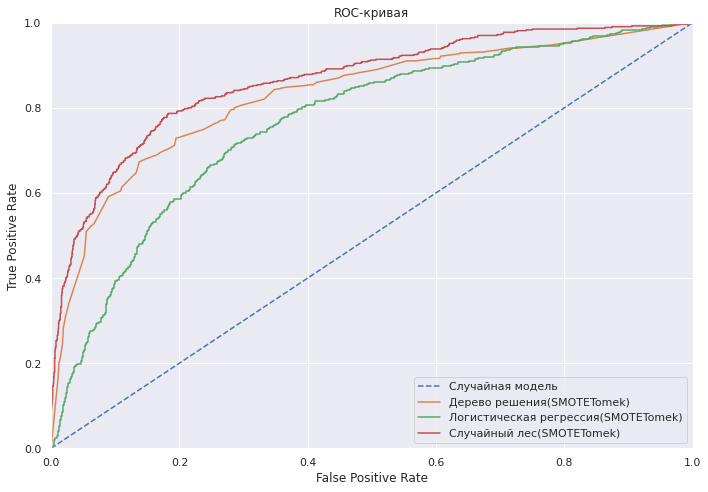

In [65]:
plt.figure()
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree_st, tpr_tree_st)
plt.plot(fpr_logic_st, tpr_logic_st)
plt.plot(fpr_st, tpr_st)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Дерево решения(SMOTETomek)','Логистическая регрессия(SMOTETomek)',
             'Случайный лес(SMOTETomek)')) 
plt.tight_layout()
plt.show()

Видно то, что ROC-кривая показала, что модель Случайного леса лучше чем Дерево решения и Логистическая регрессия.

# Общий вывод:

In [66]:
rezult = {'Дерево Решения':np.array([0.569, 0.564]), 'Случайный лес':np.array([0.568, 0.649]), \
          'Логистическая регрессия':np.array([0.293, 0.518])}
rezult_df = pd.DataFrame(rezult, index=['F1-мера без учета дисбаланса','F1-мера с учетом дисбаланса'])
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
F1-мера без учета дисбаланса,0.569,0.568,0.293
F1-мера с учетом дисбаланса,0.564,0.640,0.518


**Рассматривая данные после преобразования категориальных признаков в численные методом OneHotEncoder, стандартизации данных(маштабирования) и балансировки данных лучшим методом (SMOTETomek), можно сделать вывод, что лучшей моделью оказалась - модель Случайный лес. Ее лучшие параметры 'max_depth' = 10, 'min_samples_leaf' = 1, 'n_estimators' = 40. На итоге мы получили лучшую F1-меру = 0.64 на тестовой(валидационной) выборке, а хуже всего результаты показала модель Логистической регрессии.**